In [30]:
import datetime
import galsim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time
import webbpsf
from copy import deepcopy
from galsim import InterpolatedImage, Image, ImageF
from galsim import roman
from glob import glob
from hydra import initialize, compose
from matplotlib import colors
from pprint import pprint

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, psf, gs

In [4]:
band = 'F184'
exposure_time = 146
oversample = 5
num_pix = 45
side = 4.95

lens = SampleStrongLens()

# add CDM subhalos; NB same subhalo population for all
# lens.add_subhalos(util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample')))

# generate synthetic image
model = lens.get_array(num_pix=num_pix * oversample, side=side, band=band)

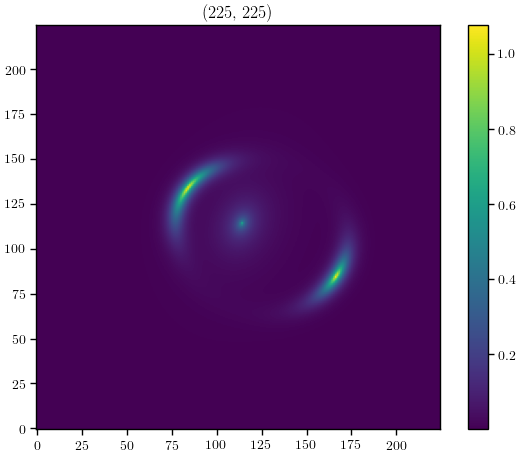

In [5]:
plt.imshow(model)
plt.title(model.shape)
plt.colorbar()
plt.show()

In [6]:
total_flux_cps = lens.get_total_flux_cps(band)

interp = galsim.InterpolatedImage(galsim.Image(model, xmin=0, ymin=0),
                                  scale=0.11 / oversample,
                                  flux=total_flux_cps * exposure_time)

In [21]:
detector = 1
detector_pos = (2048, 2048)

galsim_psf = psf.get_galsim_psf(band, detector, detector_pos)
webbpsf_psf = psf.get_webbpsf_psf(band, detector, detector_pos, oversample)

In [26]:
# f, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(galsim_psf.array)
# ax[0].set_title('Galsim PSF')
# ax[1].imshow(webbpsf_psf.array)
# ax[1].set_title('Webbpsf PSF')
# plt.show()

In [32]:
galsim_image = deepcopy(interp)
webbpsf_image = deepcopy(interp)

galsim_final = gs.convolve(galsim_image, galsim_psf, num_pix)
webbpsf_final = gs.convolve(webbpsf_image, webbpsf_psf, num_pix)

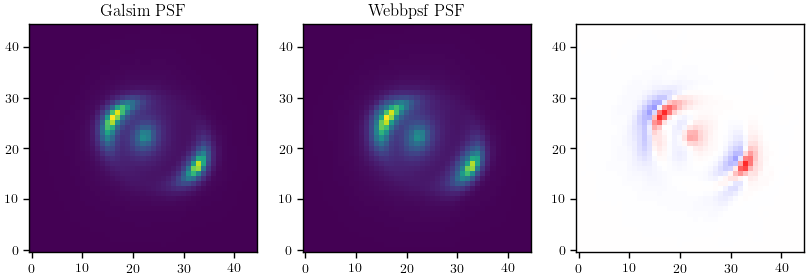

In [39]:
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(galsim_final.array)
ax[0].set_title('Galsim PSF')
ax[1].imshow(webbpsf_final.array)
ax[1].set_title('Webbpsf PSF')
ax[2].imshow(galsim_final.array - webbpsf_final.array, vmin=-1e2, vmax=1e2, cmap='bwr')
plt.show()

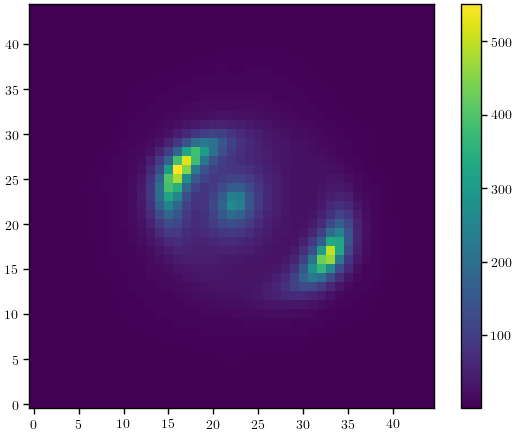

In [36]:
plt.imshow(galsim_final.array)
plt.colorbar()
plt.show()